### 1. The origination of the idea

Data-Driven Robust Optimization (https://link.springer.com/article/10.1007/s10107-017-1125-8)

Building the Uncertainty Set:

1. **<span style='color: red;'>Step 1 - Confidence Region via Hypothesis Testing</span>**:

The method starts by using a statistical hypothesis test (with a chosen significance level $\alpha$ to form a confidence region). This region consists of all distributions that are "consistent" with the observed data. In order words, with high probability (at least $1-\alpha$), the true data-generating distribution lies in this set.

- Since we are dealing with $d$ independent marginals, we adjust the significance level for each marginal test to ensure the overall confidence level is at least $1-\alpha$
$$ \alpha' = 1 - (1 - \alpha)^{1/d} $$

2. **<span style='color: red;'>Step 2 - Bounding the Worst-Case Value-at-Risk (VaR)</span>**:

The next step is to consider the worst-case Value-at-Rist (a quantile measure) of the uncertain parameter's linear function (or, more generally, any concave function) over all distributions in the confidence region. We construct a convex, positively homogeneous function $g(v, S, \epsilon, \alpha)$ that serves as an upper bound on this worse-case VaR.

- For each marginal $i$, we compute the order statistics and define the confidence region using the Kolmogorov–Smirnov test. The confidence region $\mathcal{P}_i^{KS}$ is defined as:

$$ \mathcal{P}_i^{KS} = \left\{ \mathbb{P}_i \in \Theta \left[ \hat{u}_i^{(0)}, \hat{u}_i^{(N+1)} \right] : \mathbb{P}_i \left( \tilde{u}_i \leq \hat{u}_i^{(j)} \right) \geq \frac{j}{N} - \Gamma^{KS}, \mathbb{P}_i \left( \tilde{u}_i < \hat{u}_i^{(j)} \right) \leq \frac{j-1}{N} + \Gamma^{KS}, j = 1, \ldots, N \right\}$$

   where $\Gamma^{KS}$ is the critical value for the KS test at level $\alpha'$. For large N, we approximate $\Gamma^{KS}$ using the Dvoretzky-Kiefer-Wolfowitz (DKW) inequality: 

$$ \Gamma^{KS} \approx \sqrt{\frac{-1}{2N} \log(\alpha'/2)} $$

- We also define the worst-case distributions $q^L (\Gamma^{KS})$ and $q^R (\Gamma^{KS})$ for each marginal, which are used later to compute the upper bound. 

3. **<span style='color: red;'>Step 3 - Defining the Uncertainty Set via the Support Function</span>**:

Finally, leveraging the one-to-one correspondence between convex, positively homogeneous functions and convex compact sets, the uncertainty set $U(S, \epsilon, \alpha)$ is defined so that its support function $\delta^* (v|U)$ exactly equals $g(v, S, \epsilon, \alpha)$. This set serves as the "uncertainty set" in the robust optimization mdoel. If a solution x satisfies the robust constraint for every u in U, then it will satisfy the original uncertain constraint with probability at least $1-\alpha$.

- The upper bound for the worst-case VaR over the confidence region $\mathcal{P}^I$  (product of marginal confidence regions) is:

$$ g(\mathbf{v}) = \inf_{\lambda \geq 0} \left( \lambda \log(1/\epsilon) + \lambda \sum_{i=1}^{d} \log \left[ \max \left( \sum_{j=0}^{N+1} q_j^L (\Gamma^{KS}) e^{v_i u_i^{(j)}/\lambda}, \sum_{j=0}^{N+1} q_j^R (\Gamma^{KS}) e^{v_i u_i^{(j)}/\lambda} \right) \right] \right)$$

This function is the support function $\delta^* (v|\mathcal{U})$ of the uncertainty set. We can implement $g(v)$ by optimizing over $\lambda$

### A simple demonstration with CartPole

In [1]:
# import libraries
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import scipy.optimize as optimize

device = torch.device('cpu') # if torch.cuda.is_available() else 'cpu')
################################################################################
# 1) CartPole with uncertain force magnitude 
################################################################################
class RandomCartPoleEnv: 
    """
    A simplified CartPole environment.
    The magnitude of force is treated as an uncertain parameter.
    For each episode, the force magnitude is sampled from a given range. 

    State = (x, x_dot, theta, theta_dot). => position, angle
    Action = 0 or 1 (apply force left or right)
    Reward = +1 for each step alive. 
    Episode ends if |x| > 2.4 or |theta| > 12° or steps > 200.
    """
    def __init__(self, force_range=(6.0, 12.0), seed=42):
        self.force_range = force_range
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.5
        self.total_mass = self.masscart + self.masspole
        self.length = 0.5  # pole length
        self.force_mag = 10.0 # will be reset each episode
        self.tau = 0.02
        self.max_steps = 200
        self.state = None
        self.steps = 0
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        # Sample force magnitude from the provided range
        self.force_mag = np.random.uniform(*self.force_range)
        self.steps = 0
        # Random small initial state
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return self.state.copy(), self.force_mag

    def step(self, action):
        # action=0 => force to the left, action=1 => force to the right
        state = self.state
        x, x_dot, theta, theta_dot = state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.masspole * self.length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass))
        xacc = temp - self.masspole * self.length * thetaacc * costheta / self.total_mass
        # Euler integration
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1
        done = False
        if x < -2.4 or x > 2.4 or theta < -0.20944 or theta > 0.20944:
            done = True  
        if self.steps >= self.max_steps:
            done = True
        reward = 1.0
        if done and self.steps < self.max_steps:
            reward -= 0.1
        return self.state.copy(), reward, done

In [2]:
################################################################################
# 2) Gathering Offline Data
################################################################################

def gather_offline_data_cartpole(num_episodes=200, force_range=(8.0, 12.0), seed=42):
    """
    Executes a random policy in the environment.
    Stores tuples: (s, a, s_next, force_used, r, done)
    state, action, next_state, reward, done
    """
    dataset = []
    env = RandomCartPoleEnv(force_range=force_range, seed=seed)
    for ep in range(num_episodes):
        s, f = env.reset() # take env to initial state
        done = False
        steps = 0
        while not done and steps < 200: 
            a = np.random.randint(0, 2) # 0 or 1 => random action 
            s_next, r, done = env.step(a)
            dataset.append((s.copy(), a, s_next.copy(), f, r, done))
            s = s_next
            steps += 1

    return dataset

In [3]:
################################################################################
# 3) Full uncertainty set construction schema for Force (as univariate)
################################################################################

def compute_order_statistics_and_gamma_1d(data, alpha=0.05):
    """
    Given 1D Data (force values), compute sorted order statistics (with artificial bounds)
    and the KS critical value (gamma_ks) using the DKW inequality.
    """
    N = len(data)
    sorted_data = np.sort(data)
    order_stats = np.zeros(N + 2)
    order_stats[0] = sorted_data[0]
    order_stats[1:N+1] = sorted_data
    order_stats[N+1] = sorted_data[-1]
    gamma_ks = math.sqrt(-0.5 / N * math.log(alpha / 2))
    return order_stats, gamma_ks

def compute_qL_qR(order_stats, gamma_ks):
    """
    For the given order statistics and KS critical value, compute the worst-case
    distributions q^L and q^R.
    """
    N = len(order_stats) - 2
    qL = np.zeros(N + 2)
    qR = np.zeros(N + 2)

    # for the left side
    qL[0] = gamma_ks
    k = int(np.floor(N * (1 - gamma_ks))) # floor
    if 0 <= k < N:
        for j in range(1, k + 1):
            qL[j] = 1.0 / N
        qL[k + 1] = 1 - gamma_ks - k / N

    # for the right side
    qR[-1] = gamma_ks
    k = int(np.ceil(N * gamma_ks)) # ceiling
    if 0 < k <= N:
        for j in range(N - k + 1, N + 1):
            qR[j] = 1.0 / N
        qR[N - k] = 1 - gamma_ks - (k - 1) / N
        
    return qL, qR

def compute_support_function(v, order_stats, qL, qR, epsilon):
    """
    Compute the support function g(v) for the uncertain force using the worst-case
    distributions (qL and qR) from the KS-based confidence region. 
    For a linear function and uncertainty set U, the support function is:
     g(v) = max_{u in U} (v * u)
    Here, U is approximated via the worst-case distributions over the order statistics.
     g(v) = min_{lambda > 0} { lambda * log(1/epsilon) + lambda * log( max( sum(qL*exp(v*order_stats/lambda)), sum(qR*exp(v*order_stats/lambda)) ) ) }
    """
    def objective(lmbda):
        if lmbda <= 0:
            return np.inf
        term = lmbda * np.log(1.0 / epsilon)
        z = (v * order_stats) / lmbda
        z = np.clip(z, -50, 50)
        sumL = np.sum(qL * np.exp(z))
        sumR = np.sum(qR * np.exp(z))
        max_exp = max(sumL, sumR)
        term += lmbda * np.log(max_exp)
        return term

    result = optimize.minimize_scalar(objective, bounds=(1e-6, 1000), method='bounded')
    if result.success:
        return result.fun
    else:
        return np.inf

In [4]:
################################################################################
# 4) Build KS confidence region and support function for force
################################################################################

def build_uncertainty_force(dataset, alpha=0.05, epsilon=0.1):
    """
    Constructs the full uncertainty set for the force parameter using the KS-based approach.
    Returns:
       - The interval [f_L, f_U],
       - The order statistics,
       - The worst-case distributions (qL, qR),
       - The support function value for a given sensitivity v.
    """
    f_vals = np.array([row[3] for row in dataset])
    order_stats, gamma_ks = compute_order_statistics_and_gamma_1d(f_vals, alpha)
    qL, qR = compute_qL_qR(order_stats, gamma_ks)
    # The basic interval is simply:
    f_L = order_stats[0]
    f_U = order_stats[-1]
    return (f_L, f_U), order_stats, qL, qR, epsilon

In [5]:
################################################################################
# 5) Networks (enhanced architecture)
################################################################################

class QNetCartPole(nn.Module):
    """
    Q-Network with batch normalization and dropout.
    Adding dropout for btter generalization.
    """

    def __init__(self, state_dim=4, hidden_dim=68, action_dim=2, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim) # Batch normalization applied 
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim) 
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, s):
        # if s.dim() == 1:
        #     s = s.unsqueeze(0) # Add batch dimension if needed
        x = F.relu(self.bn1(self.fc1(s)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        q = self.fc3(x) # Q-values

        return q

class PolicyNetwork(nn.Module):
    """
    Policy network for BCQ implementation.
    """
    def __init__(self, state_dim=4, hidden_dim=68, action_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, s):
        # if s.dim() == 1:
        #     s = s.unsqueeze(0)
        x = F.relu(self.bn1(self.fc1(s)))
        x = F.relu(self.bn2(self.fc2(x)))
        action_probs = F.softmax(self.fc3(x), dim=1) # return a prob_distribution => stochastic
        return action_probs
        

In [6]:
################################################################################
# 6) Robust RL approach using the full uncertainty schema
################################################################################

class RobustOfflineRLCartPole:
    """
    A DQN-like agent that learns Q(s) -> 2 actions
    In offline updates, it uses the full uncertainty construction for the force parameter.
    Given an offline datset, we first construct the uncertainty set U for force (using KS,
    qL, qR, and a support function). Then, during updates, for each transition, we simulate
    the next state with force values in U and use the worst-case (minimum) Q-value as robust backup.
    """

    def __init__(self, uncertainty_force, gamma=0.99, lr=1e-3, hidden_dim=68, dropout_rate=0.1):
        # here the uncertainty_force is a tuple: (force_interval, order_stats, qL, qR, epsilon)
        (self.f_L, self.f_U), self.order_stats, self.qL, self.qR, self.epsilon = uncertainty_force
        self.gamma = gamma
        self.qnet = QNetCartPole(state_dim=4, hidden_dim=hidden_dim, action_dim=2, dropout_rate=dropout_rate)
        self.qnet.to(device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr, weight_decay=1e-4)
        self.name = "Robust RL"
        # In this toy example, the suuport function for a given sensitivity v can be computed. 
        # In a univariate setting, if v >= 0, then support function = v * self.f_U
        # if v < 0, then support function = v * self.f_L. 

    def simulate_step(self, s, a, force):
        """
        Replicate the one step of CartPole dynamics with a given force. 
        Returns the next state and done flag.
        """
        x, x_dot, theta, theta_dot = s
        f = force if a == 1 else -force
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        total_mass = 1.0 + 0.5
        length = 0.5
        tau = 0.02
        temp = (force + 0.5 * length * theta_dot**2 * sintheta) / total_mass
        thetaacc = (9.8 * sintheta - math.cos(theta) * temp) / (length * (4.0/3.0 - 0.5 * math.cos(theta)**2 / total_mass))
        xacc = temp - 0.5 * length * thetaacc * math.cos(theta) / total_mass
        x2 = x + tau * x_dot
        x_dot2 = x_dot + tau * xacc
        theta2 = theta + tau * theta_dot
        theta_dot2 = theta_dot + tau * thetaacc

        next_s = np.array([x2, x_dot2, theta2, theta_dot2], dtype=float)
        done = (x2 < -2.4 or x2 > 2.4 or theta2 < -0.20944 or theta2 > 0.20944)
        return next_s, done

    def support_value(self, v):
        """
        Compute the support function value for a given sensitivity v using the full uncertainty schema.
        """
        return compute_support_function(v, self.order_stats, self.qL, self.qR, self.epsilon)
        
    def robust_backup(self, s, a):
        """
        Computes the robust backup target:
         y = r + gamma * min_{f in U} [ max_{a'} Q(s_next(f), a') ]
        Approximate this by evaluating the Q-network at a set of force values and taking the minimum. 
        Define a sensitivity v, the support function g(v) yields an upper bound on v^T for f in U
        """
        num_sensitivity_samples = 3 # number of random sensitivity vectors
        worst_case_q = float('inf')

        for _ in range(num_sensitivity_samples):
            # Generate a sensitvity vector v
            v = np.random.normal(0, 1)

            # Compute support function value g(v) -> gives worst-case force
            worst_case_force = self.support_value(v)

            # simulate the worst-case transition using that force
            s_next, done = self.simulate_step(s, a, worst_case_force)

            if done:
                worst_case_q = min(worst_case_q, 0.0)
            else:
                s_next_t = torch.FloatTensor(np.array(s_next)).unsqueeze(0).to(device)
                q_next = self.qnet(s_next_t).max(dim=1)[0].item()
                worst_case_q = min(worst_case_q, q_next)
        
        return worst_case_q

    def update_from_batch(self, batch):
        """
        Performs a robust DQN update:
        - use the support function to determine the worst-case force scenario
        - computes the robust target y using the worst-case Q-value
        """
        states, actions, rewards, dones = [], [], [], []
        for (s, a, s_next, f, r, d) in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            dones.append(d)

        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).unsqueeze(1).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).unsqueeze(1).to(device)

        qvals = self.qnet(states_t)
        gather_q = qvals.gather(1, actions_t)

        with torch.no_grad():
            self.qnet.eval()
            nextQ_list = []
            for i in range(len(batch)):
                if dones[i]:
                    nextQ_list.append(0.0)
                else:
                    robust_q = self.robust_backup(states[i], actions[i])
                    nextQ_list.append(robust_q)
            self.qnet.train()
            nextQ_t = torch.FloatTensor(np.array(nextQ_list)).unsqueeze(1).to(device)

        y = rewards_t + (~dones_t).float() * self.gamma * nextQ_t
        loss = F.mse_loss(gather_q, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def get_action(self, s):
        """
        Greedy action selection for evaluation.
        Sets network to eval mode to avoid BatchNorm issues 
        """
        self.qnet.eval()
        s_t = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
        with torch.no_grad():
            qvals = self.qnet(s_t)[0]
        a_ = torch.argmax(qvals).item()
        self.qnet.train()
        return a_


In [7]:
################################################################################
# 7) Domain Randomization RL
################################################################################

class DomainRandCartPole:
    def __init__(self, force_range=(8.0,12.0), gamma=0.99, lr=1e-3, hidden_dim=128, dropout_rate=0.1):
        self.f_min, self.f_max = force_range
        self.gamma = gamma
        self.qnet = QNetCartPole(state_dim=4, hidden_dim=hidden_dim, action_dim=2, dropout_rate=dropout_rate)
        self.qnet.to(device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr, weight_decay=1e-4)
        self.name = "DomainRand RL"

    def simulate_step(self, s, a, force):
        x, x_dot, theta, theta_dot = s
        f = force if a == 1 else -force
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        total_mass = 1.0 + 0.5
        length = 0.5
        tau = 0.02
        temp = (force + 0.5 * length * theta_dot**2 * sintheta) / total_mass
        thetaacc = (9.8 * sintheta - math.cos(theta) * temp) / (length * (4.0/3.0 - 0.5 * math.cos(theta)**2 / total_mass))
        xacc = temp - 0.5 * length * thetaacc * math.cos(theta) / total_mass
        x2 = x + tau * x_dot
        x_dot2 = x_dot + tau * xacc
        theta2 = theta + tau * theta_dot
        theta_dot2 = theta_dot + tau * thetaacc
        next_s = np.array([x2, x_dot2, theta2, theta_dot2], dtype=float)
        done = (x2 < -2.4 or x2 > 2.4 or theta2 < -0.20944 or theta2 > 0.20944)
        return next_s, done

    def update_from_batch(self, batch):
        states, actions, rewards, dones = [], [], [], []
        for (s, a, s_next, f, r, d) in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            dones.append(d)
        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).unsqueeze(1).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).unsqueeze(1).to(device)
        qvals = self.qnet(states_t)
        gather_q = qvals.gather(1, actions_t)
        with torch.no_grad():
            self.qnet.eval()
            nextQ_list = []
            num_samples = 3
            for i in range(len(batch)):
                if dones[i]:
                    nextQ_list.append(0.0)
                    continue
                q_vals = []
                for _ in range(num_samples):
                    force_rand = np.random.uniform(self.f_min, self.f_max)
                    s_np = states[i]
                    a_np = actions[i]
                    s_next_rand, done_rand = self.simulate_step(s_np, a_np, force_rand)
                    if done_rand:
                        q_vals.append(0.0)
                    else:
                        s_next_rand_t = torch.FloatTensor(np.array(s_next_rand)).unsqueeze(0).to(device)
                        q_val = self.qnet(s_next_rand_t).max(dim=1)[0].item()
                        q_vals.append(q_val)
                nextQ_list.append(np.mean(q_vals))
            self.qnet.train()
            nextQ_t = torch.FloatTensor(np.array(nextQ_list)).unsqueeze(1).to(device)
        y = rewards_t + (~dones_t).float() * self.gamma * nextQ_t
        loss = F.mse_loss(gather_q, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def get_action(self, s):
        self.qnet.eval()
        s_t = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
        with torch.no_grad():
            qvals = self.qnet(s_t)[0]
        a_ = torch.argmax(qvals).item()
        self.qnet.train()
        return a_

In [8]:
################################################################################
# 8) BCQ and CQL implementations (assume similar eval mode handling)
################################################################################
class BCQCartPole:
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=128, gamma=0.99, lr=1e-3, 
                 tau=0.005, threshold=0.3, dropout_rate=0.1):
        self.gamma = gamma
        self.tau = tau
        self.threshold = threshold
        self.q_net = QNetCartPole(state_dim, hidden_dim, action_dim, dropout_rate)
        self.q_net.to(device)
        self.target_q_net = QNetCartPole(state_dim, hidden_dim, action_dim, dropout_rate)
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.policy_net = PolicyNetwork(state_dim, hidden_dim, action_dim)
        self.policy_net.to(device)
        self.q_optimizer = optim.Adam(self.q_net.parameters(), lr=lr, weight_decay=1e-4)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=lr, weight_decay=1e-4)
        self.action_counts = np.zeros(action_dim)
        self.total_actions = 0
        self.name = "BCQ"
        
    def preprocess_dataset(self, dataset):
        for (_, a, _, _, _, _) in dataset:
            self.action_counts[a] += 1
            self.total_actions += 1
    
    def update_from_batch(self, batch):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for item in batch:
            s, a, s_next, _, r, d = item
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(s_next)
            dones.append(d)
        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).unsqueeze(1).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        next_states_t = torch.FloatTensor(np.array(next_states)).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).unsqueeze(1).to(device)
        # Update behavior policy
        action_probs = self.policy_net(states_t)
        policy_loss = F.cross_entropy(action_probs, actions_t.squeeze(1))
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        with torch.no_grad():
            next_action_probs = self.policy_net(next_states_t)
            mask = (next_action_probs >= self.threshold * next_action_probs.max(1, keepdim=True)[0])
            next_q = self.target_q_net(next_states_t)
            next_q[~mask] = -1e9
            next_q_max = next_q.max(1, keepdim=True)[0]
            target_q = rewards_t + (~dones_t).float() * self.gamma * next_q_max
        q_values = self.q_net(states_t)
        current_q = q_values.gather(1, actions_t)
        q_loss = F.mse_loss(current_q, target_q)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(target_param.data*(1.0 - self.tau) + param.data*self.tau)
        return q_loss.item() + policy_loss.item()
    
    def get_action(self, s):
        self.policy_net.eval()
        self.q_net.eval()
        s_t = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
        with torch.no_grad():
            action_probs = self.policy_net(s_t)
            mask = (action_probs >= self.threshold * action_probs.max(1, keepdim=True)[0])
            q_values = self.q_net(s_t)
            q_values[~mask] = -1e9
            action = q_values.argmax(dim=1).item()
        self.policy_net.train()
        self.q_net.train()
        return action

class CQLCartPole:
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=128, gamma=0.99, lr=1e-3, 
                 tau=0.005, cql_alpha=1.0, dropout_rate=0.1):
        self.gamma = gamma
        self.tau = tau
        self.cql_alpha = cql_alpha
        self.action_dim = action_dim
        self.q_net = QNetCartPole(state_dim, hidden_dim, action_dim, dropout_rate)
        self.q_net.to(device)
        self.target_q_net = QNetCartPole(state_dim, hidden_dim, action_dim, dropout_rate)
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr, weight_decay=1e-4)
        self.name = "CQL"
    
    def update_from_batch(self, batch):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for item in batch:
            s, a, s_next, _, r, d = item
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(s_next)
            dones.append(d)
        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).unsqueeze(1).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        next_states_t = torch.FloatTensor(np.array(next_states)).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).unsqueeze(1).to(device)
        with torch.no_grad():
            next_q = self.target_q_net(next_states_t)
            next_q_max = next_q.max(1, keepdim=True)[0]
            target_q = rewards_t + (~dones_t).float() * self.gamma * next_q_max
        q_values = self.q_net(states_t)
        q_chosen = q_values.gather(1, actions_t)
        cql_logsumexp = torch.logsumexp(q_values, dim=1, keepdim=True)
        cql_regularizer = (cql_logsumexp - q_chosen).mean()
        q_loss = F.mse_loss(q_chosen, target_q)
        total_loss = q_loss + self.cql_alpha * cql_regularizer
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(target_param.data*(1.0 - self.tau) + param.data*self.tau)
        return total_loss.item()
    
    def get_action(self, s):
        self.q_net.eval()
        s_t = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(s_t)
            action = q_values.argmax(dim=1).item()
        self.q_net.train()
        return action

In [9]:
################################################################################
# 9) Enhanced Evaluation Functions
################################################################################

def evaluate(agent, force, n_episodes=50, max_steps=200):
    total_reward = 0
    episode_lengths = []
    success_count = 0
    for ep in range(n_episodes):
        env = RandomCartPoleEnv(force_range=(force, force))
        s, _ = env.reset()
        done = False
        steps = 0
        ep_reward = 0
        while not done and steps < max_steps:
            a = agent.get_action(s)
            s, r, done = env.step(a)
            ep_reward += r
            steps += 1
        total_reward += ep_reward
        episode_lengths.append(steps)
        if steps >= max_steps - 1:
            success_count += 1
    avg_reward = total_reward / n_episodes
    avg_length = np.mean(episode_lengths)
    success_rate = (success_count / n_episodes) * 100
    return {'avg_reward': avg_reward, 'avg_length': avg_length, 'success_rate': success_rate}

def demonstrate_control(agent, force=9.0, max_steps=200):
    env = RandomCartPoleEnv(force_range=(force, force))
    state, _ = env.reset()
    x_list, theta_list, reward_list = [], [], []
    step_count = 0
    done = False
    while not done and step_count < max_steps:
        a = agent.get_action(state)
        state, r, done = env.step(a)
        x_list.append(state[0])
        theta_list.append(state[2])
        reward_list.append(r)
        step_count += 1
    total_reward = sum(reward_list)
    print(f"Demonstration at force={force:.2f}: Survived {step_count}/{max_steps} steps, Total reward: {total_reward:.2f}")
    t_axis = np.arange(step_count)
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t_axis, x_list, 'b-', label="Cart Position (x)")
    plt.axhline(y=2.4, color='r', linestyle='--', label="Failure Bound ±2.4")
    plt.axhline(y=-2.4, color='r', linestyle='--')
    plt.xlabel("Timestep")
    plt.ylabel("Position")
    plt.title(f"Agent: {agent.name}, Force={force:.2f}, Survived: {step_count} steps")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(t_axis, theta_list, 'g-', label="Pole Angle (theta, rad)")
    plt.axhline(y=0.20944, color='r', linestyle='--', label="Failure Bound ±12°")
    plt.axhline(y=-0.20944, color='r', linestyle='--')
    plt.xlabel("Timestep")
    plt.ylabel("Pole Angle (rad)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_agents_on_range(agents, forces=[6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0], n_episodes=30):
    results = {}
    for agent in agents:
        reward_list = []
        length_list = []
        success_list = []
        for f in forces:
            metrics = evaluate(agent, force=f, n_episodes=n_episodes, max_steps=200)
            reward_list.append(metrics['avg_reward'])
            length_list.append(metrics['avg_length'])
            success_list.append(metrics['success_rate'])
        results[agent.name] = {'reward': reward_list, 'length': length_list, 'success': success_list}
    plt.figure(figsize=(10,5))
    for agent in agents:
        plt.plot(forces, results[agent.name]['reward'], marker='o', label=f"{agent.name}")
    plt.xlabel("Force magnitude")
    plt.ylabel("Average Reward")
    plt.title("Average Reward vs. Force Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(10,5))
    for agent in agents:
        plt.plot(forces, results[agent.name]['success'], marker='s', label=f"{agent.name}")
    plt.xlabel("Force magnitude")
    plt.ylabel("Success Rate (%)")
    plt.title("Success Rate vs. Force Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()
    return results

Dataset size: 485
Full uncertainty force interval: [6.096, 11.570]


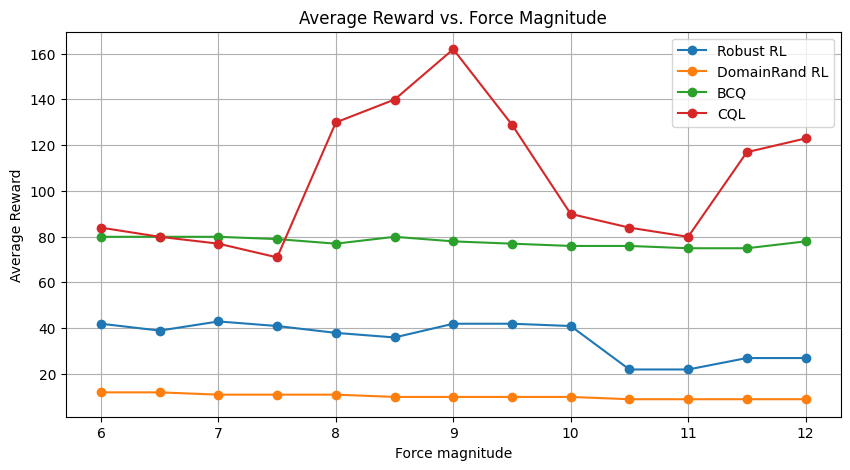

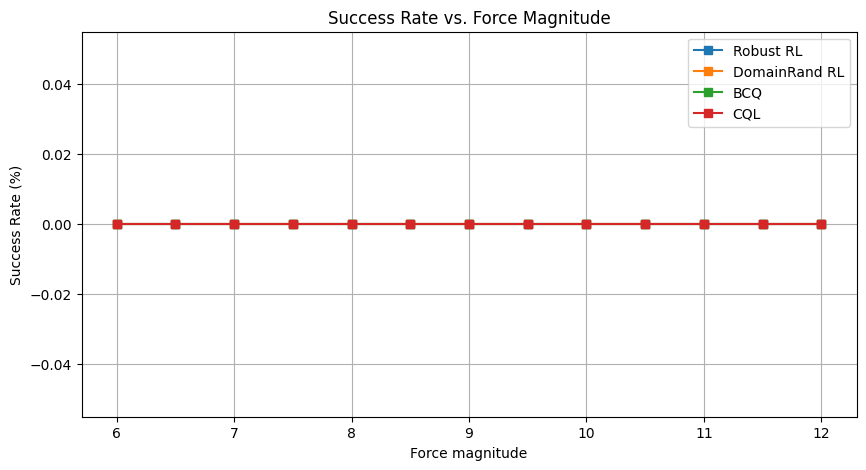

Demonstration at force=9.00: Survived 42/200 steps, Total reward: 41.90


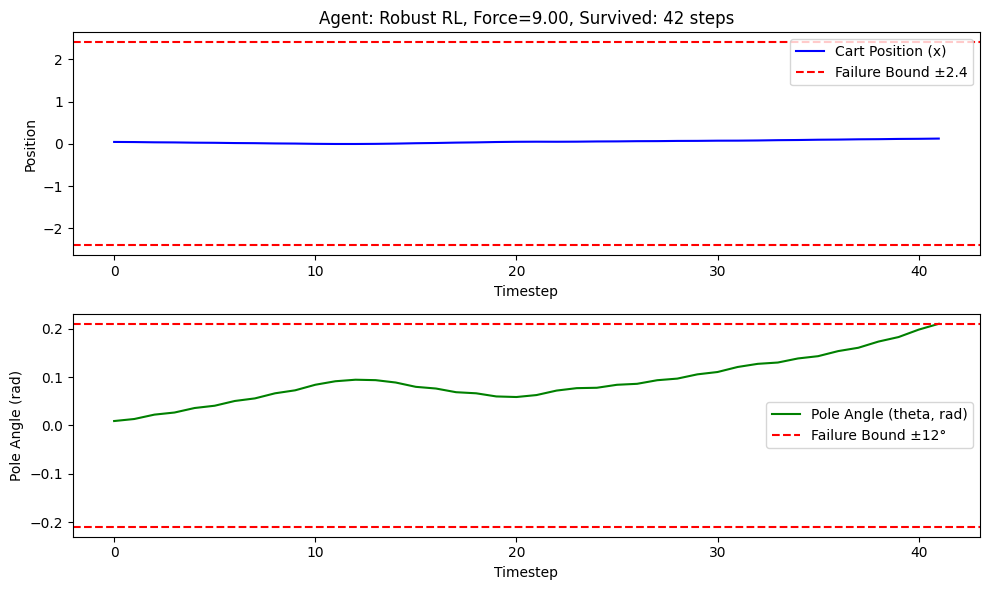

Demonstration at force=9.00: Survived 10/200 steps, Total reward: 9.90


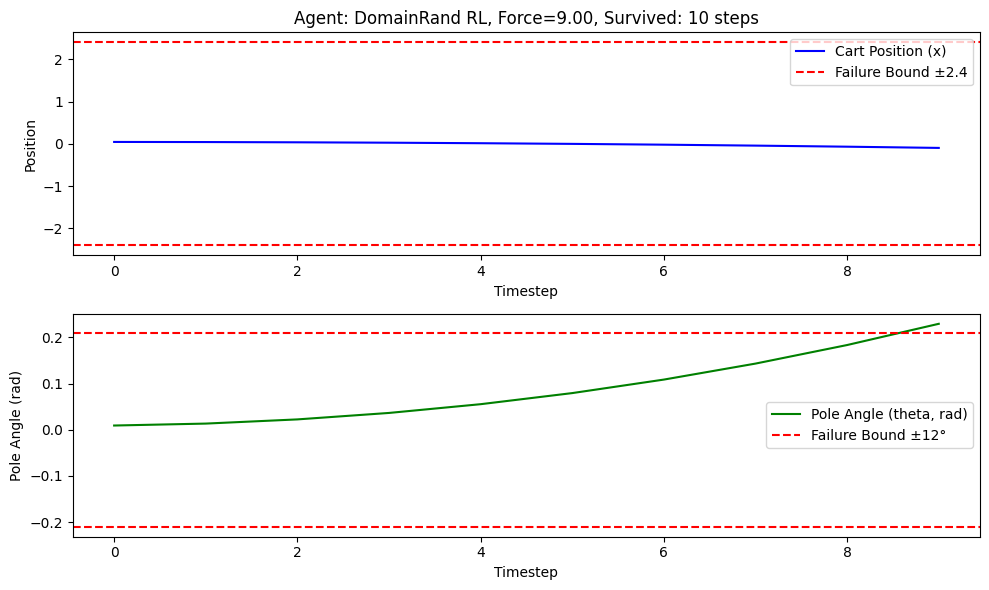

Demonstration at force=9.00: Survived 78/200 steps, Total reward: 77.90


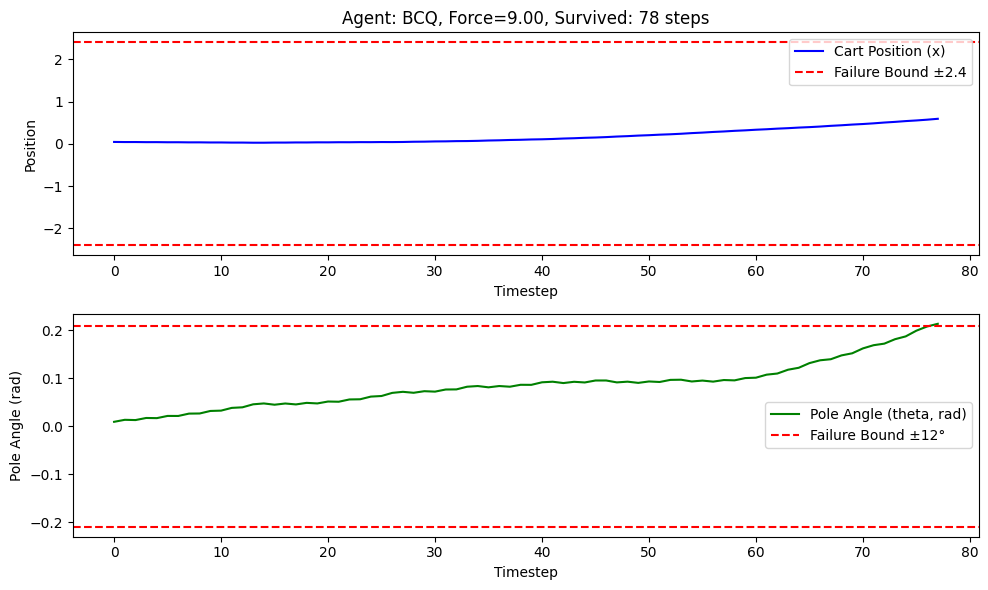

Demonstration at force=9.00: Survived 162/200 steps, Total reward: 161.90


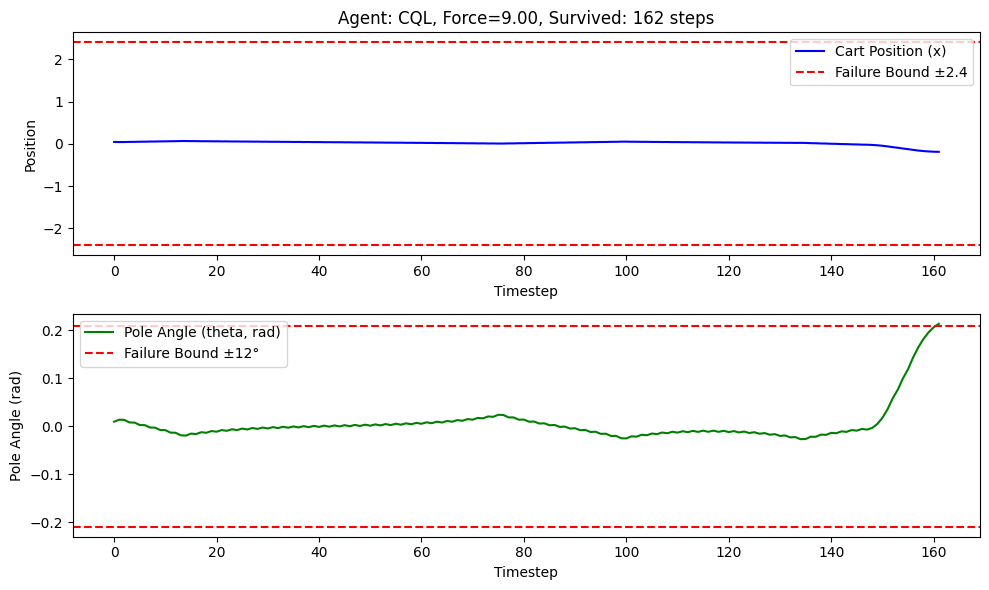

In [10]:
################################################################################
# 10) Demonstration & Comparison
################################################################################

def main_demo():
    # 1) Build offline dataset
    dataset = gather_offline_data_cartpole(num_episodes=20, force_range=(6.0, 12.0), seed=42)
    print("Dataset size:", len(dataset))
    
    # 2) Build full uncertainty set for force using the full schema
    uncertainty_force = build_uncertainty_force(dataset, alpha=0.05, epsilon=0.1)
    (f_L, f_U), order_stats, qL, qR, eps = uncertainty_force
    print(f"Full uncertainty force interval: [{f_L:.3f}, {f_U:.3f}]")
    
    # 3) Instantiate agents: pass the full uncertainty tuple to RobustOfflineRLCartPole
    robust_agent = RobustOfflineRLCartPole(uncertainty_force=((f_L, f_U), order_stats, qL, qR, eps))
    domain_agent = DomainRandCartPole(force_range=(6.0, 12.0))
    bcq_agent = BCQCartPole()
    cql_agent = CQLCartPole()
    bcq_agent.preprocess_dataset(dataset)
    
    # 4) Offline training loop
    random.shuffle(dataset)
    batch_size = 64
    epochs = 20
    for e in range(epochs):
        random.shuffle(dataset)
        start = 0
        while start < len(dataset):
            batch_data = dataset[start:start+batch_size]
            robust_agent.update_from_batch(batch_data)
            domain_agent.update_from_batch(batch_data)
            bcq_agent.update_from_batch(batch_data)
            cql_agent.update_from_batch(batch_data)
            start += batch_size
    
    # 5) Evaluate agents across multiple force magnitudes
    agents = [robust_agent, domain_agent, bcq_agent, cql_agent]
    results = compare_agents_on_range(agents, forces=[6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0], n_episodes=30)
    
    # 6) Demonstration - single episode time-series at force=9.0
    demonstrate_control(robust_agent, force=9.0, max_steps=200)
    demonstrate_control(domain_agent, force=9.0, max_steps=200)
    demonstrate_control(bcq_agent, force=9.0, max_steps=200)
    demonstrate_control(cql_agent, force=9.0, max_steps=200)

if __name__ == "__main__":
    main_demo()

### 2. Offline Robust Reinforcement Learning (I found this paper later this week and realized that similar work has been done)

Robust Reinforcement Learning using offline data (https://proceedings.neurips.cc/paper_files/paper/2022/file/d01bda31bbcd780774ff15b534e03c40-Paper-Conference.pdf)

The goal of robust reinforcement learning (RL) is to learn a policy that is robust against the uncertainty in model parameters. Parameter uncertainty commonly occurs in many real-world RL applications due to simulator modeling errors, changes in the real-world system dynamics over time, and adversarial disturbances. Robust RL is typically formulated as a max-min problem, where the objective is to learn the policy that maximizes the value against the worst possible models that lie in an uncertainty set. In this work, we propose a robust RL algorithm called Robust Fitted Q-Iteration (RFQI), which uses only an offline dataset to learn the optimal robust policy. Robust RL with offline data is significantly more challenging than its non-robust counterpart because of the minimization over all models present in the robust Bellman operator. This poses challenges in offline data collection, optimization over the models, and unbiased estimation. In this work, we propose a systematic approach to overcome these challenges, resulting in our RFQI algorithm. We prove that RFQI learns a near-optimal robust policy under standard assumptions and demonstrate its superior performance on standard benchmark problems.

Key differences: 

* My approach:
  I build uncertainty sets over environment parameters using hypothesis testing. By collecting environment-parameter samples, form confidence regions (e.g., bounding boxes or distribution sets) and then do robust optimization: $\max_{\pi} \min_{u \in U} \mathbb{E}_{P_u} [R(\pi)]$
  => I tackle parametric uncertainty about the environment (distribution over system parameters)
* This paper:
  They focus on robustness against adversial or noisy state observations in an offline setting. Instead of building a set of plausible environment parameters, they concern small (or moderate) perturbations to the observed states that might cause large changes in Q-values or policy outputs.
  => RORL tackles observation perturbations or "adversarial states" near the offline dataset



### 3. Adapting the approach in a process engineering setting

**_Context: In a chemical engineering setting with multiple loops of PID controllers, we likely have vast amounts of data capturing both the system dynamics and control actions_**

Building the Uncertainty Set from Data

1. Statistical Confidence Region:
   Start by applying hypothesis tests to the recorded data. For example, use tests like the **Kolmogorov–Smirnov test or Student’s t-test** on key performance indicators or process parameters. These tests help construct a confidence region — a collection of distributions that, with high probability, contains the true underlying dynamics of your process.

2. Bounding the Worst-Case Risk:
   Once we have a confidence region, the next step is to **quantify uncertainty in a performance-relevant way**. The method does this by _computing an upper bound on the worst-case Value-at-Risk (VaR)_ for functions that describe the system performance (for instance, deviations from desired operating conditions). This bound is convex and positively homogeneous, meaning it scales well and can be optimized over.


3. Deriving the Uncertainty Set:
   Finally, by inverting this worst-case risk bound, we define a convex uncertainty set. This set captures the range of possible deviations in system behavior in a way that is tight (i.e., less conservative) compared to traditional methods that might simply take the entire support of the data. The resulting set is not only **data-driven but also computationally tractable for robust optimization**.

Benefits in our Context:

1. **Reduced conservatism**:
   By using the data to tailor the uncertainty set, we avoid the overly conservative estimates that can result from worst-case assumptions. This means that the robust controllers designed using this method can achieve better performance while still maintaining safety guarantees.

2. **Scalability and Tractability**:
   The convexity and explicit representation of the uncertainty sets make them suitable for large-scale problems. In our scenario, where many PID controllers interact within a large process, computational efficiency is crucial.

3. **Probabilistic Guarantees**:
   The methodology provides rigorous probabilistic guarantees. If a control strategy satisfies the robust constraints over the uncertainty set, then with high confidence it will perform well under the true process uncertainties.

### CSTR Case Study: Multiple-Loop PID Control Problem

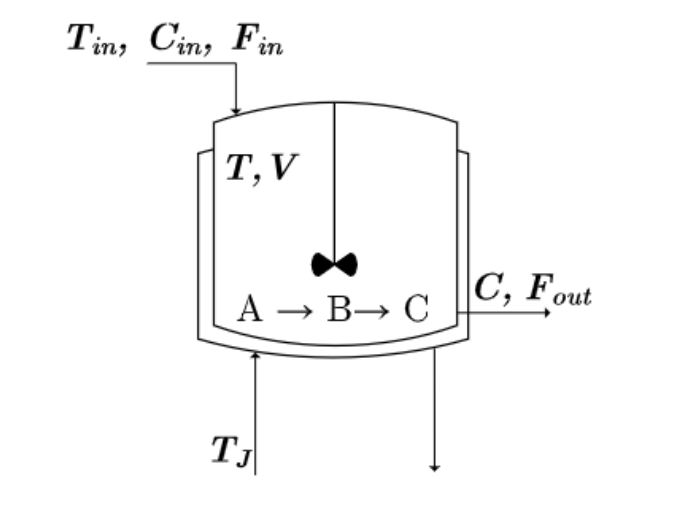

* Two independent control loops: one for **temperature**, one for **volume/flow rate**.
* Strong interactions: Adjusting $T_c$ affects reaction rates and thus concentrations, which in turn affect volume.
* Decouping is needed: Because changing **flow rate affects temperature and vice versa**, traditional PID tuning may struggle.
* Requires tuning coordincations: Simple single-loop PID tuning is insufficient due to cross-coupling effects. 

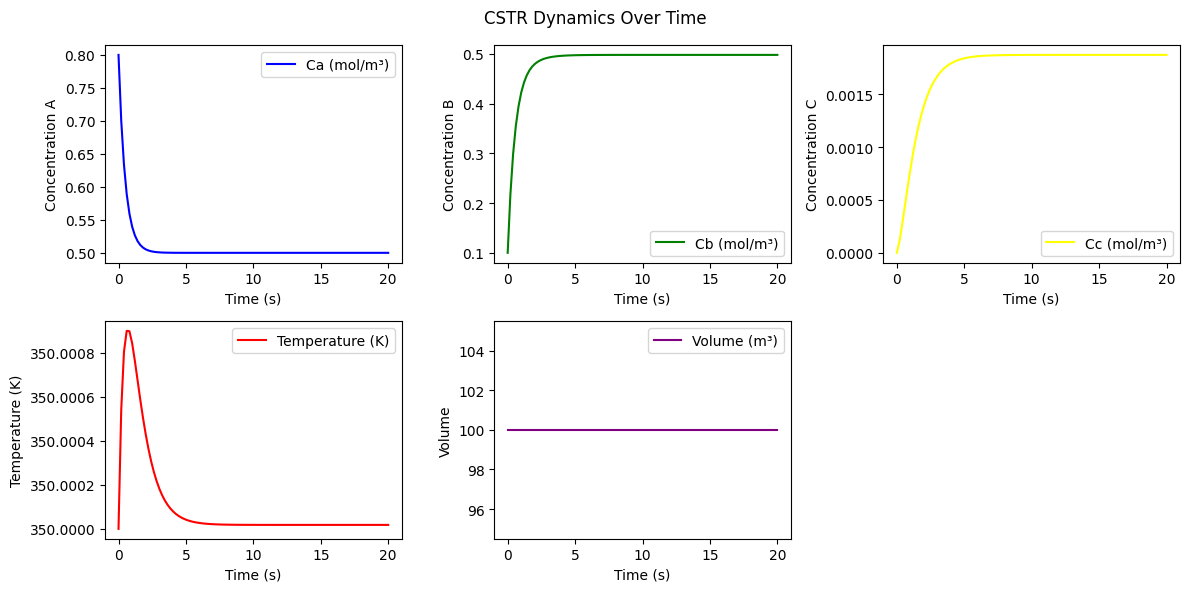

In [11]:
################################################
############# System Simulation ################
################################################
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def cstr_model(x, t, u, Tf, Caf):
    """
    Dynamic model of a CSTR with cooling jacket and proper unit consistency.
    """
    # Inputs (Control Variables)
    Tc = u[0]   # Cooling jacket temperature (K)
    Fin = u[1]  # Inlet flow rate (m³/s)

    # States (Process Variables)
    Ca, Cb, Cc, T, V = x  # [mol/m³, mol/m³, mol/m³, K, m³]

    # Process Parameters (with Units)
    Fout = Fin
    rho = 1000
    Cp = 4160
    Cp_rho = rho * Cp   # ~4.18e6 J/(m³·K)
    UA = 5e4            # Heat transfer coefficient * area (W/K)

    # Reaction Parameters (exothermic → positive ΔH)
    mdelH_AB = 50000   # J/mol
    mdelH_BC = 40000   # J/mol

    EoverR_AB = 8750
    k0_AB = 7.2e10
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca

    EoverR_BC = 10750
    k0_BC = 8.2e10
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb

    # --- Mass Balances ---
    dCadt = (Fin * (Caf - Ca) / V) - rA
    dCbdt = rA - rB - (Fout * Cb / V)
    dCcdt = rB - (Fout * Cc / V)

    # --- Energy Balance (K/s) ---
    dTdt = (Fin / V) * (Tf - T) \
           + (mdelH_AB / Cp_rho) * rA \
           + (mdelH_BC / Cp_rho) * rB \
           + (UA / (Cp_rho * V)) * (Tc - T)

    # --- Volume Balance (m³/s) ---
    dVdt = Fin - Fout

    return [dCadt, dCbdt, dCcdt, dTdt, dVdt]


# ------------------------------
# Simulation Parameters
# ------------------------------
t = np.linspace(0, 20, 100)    # Time (s)
x0 = [0.8, 0.1, 0.0, 350, 100]  # Initial [Ca, Cb, Cc, T, V]
u = [300, 100]                  # [Coolant T (K), Flow rate (m³/s)]
Tf = 350                        # Feed temperature (K)
Caf = 1.0                       # Feed concentration of A (mol/m³)

# Solve the differential equations
sol = odeint(cstr_model, x0, t, args=(u, Tf, Caf))

# ------------------------------
# Plot Results
# ------------------------------
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(t, sol[:, 0], label='Ca (mol/m³)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Concentration A')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(t, sol[:, 1], label='Cb (mol/m³)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Concentration B')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(t, sol[:, 2], label='Cc (mol/m³)', color='yellow')
plt.xlabel('Time (s)')
plt.ylabel('Concentration C')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(t, sol[:, 3], label='Temperature (K)', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
# Turn off scientific notation for Temperature:
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(t, sol[:, 4], label='Volume (m³)', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Volume')
plt.legend()

plt.suptitle('CSTR Dynamics Over Time')
plt.tight_layout()
plt.show()


### Feasibility of Offline Robust RL for Multiple Loop PID Tuning

#### 1. Different PID Architectures (Cascade -- nested loops; Decentralized -- independent loops; fully coupled MIMO)

* Cascade Control: Common in industry for disturbance rejection (the inner loop handles disturbances before they affect the outer loop)

  - An RL agent could be used to tune PID gains of both inner and outer loops, either sequentially or jointly.
 
  - The **pros** are that 1. RL can potentially learn an optimal coordination between loops - e.g., ensureing the inner loop is fast enough relative to the outer loop using historical data of disturbances and setpoint changes. 2. The inner loop effectively modifies the plant dynamics seen by the outer loop, so an RL policy that accounts for this can achieve superior performance to traditional tuning. For example, Ishihara et al. (2023) kept a cascaded PID as a base controller for a quadcopter and used an RL policy to provide a residual correction, significantly improving disturbance rejection (50% less drift under wind).
 
  - The **cons** are that 1. increased state dimensionality for RL (the agent sees both inner-loop and outer-loop states) and potential non-Markovian effects if the innner loop dynamics are fast. If the offline dataset does not capture the inner loop's high-frequency behavior well, the RL agent will struggle. => The agent can focus on optimizing one loop at a time or use a hierarchical policy. 
 
* Decentralized Multi-Loop Control: uses multiple independent PID loops (each controller manipulates a different input to control a corresponding output) with minimal coordination. It is often applied to MIMO systems by pairing each actuator to one sensor and tuning each PID as if it were single-loop.

  - We could train seperate RL agents for each loop using the historical data for that loop, or a single agent with a factored action space.
 
  - The **pros** are: Modularity - each loop's data (setpoint changes, disturbances affecting that loop) can be used to train an RL policy to tune that loop's PID gains. This reduces complexity, as each agent solves a smaller problem. If interactions betweeen loops are weak (or have been largely decoupled by design), offline RL policy can yield efficient tuning similar to SISO cases.
 
  - The **cons** are: A purely decentralized approach have problems when there are strong interactions between loops (coupling effects) => lead to suboptimal or even conflicting PID settings. Ensuring robustness here would require that the offline dataset for each loop adequately reflects variation in the other loop's behavior, which is hard if interfere with each other in deployment.
 
  - Potential solution? Trian a centralized RL agent that observes all relevant loop states but still outputs separate PID tuning adjustments per loop. 

* Fully Coupled MIMO PID Systems: A fully coupled system controls multiple outputs with multiple inputs without assuming any loop decoupling. This involves multiple PID controllers with cross-coupling compensation or a single multi-input multi-output control law.

  - This is the most challenging scenario. A single RL policy would need to tune all PID gains (or directly output multi-dimensional control actions) in a coordinated way.
 
  - The **pros** are: 1. RL can (in principle) handle complex multivariate relationships beteer than classifical decoupled tuning. It can learn to exploit coupling for performance (e.g., using one actuator to assist another loop when needed) by optimizing the true multi-variable objective rather than treating loops independently. => Doerr et al. (2017) demonstrated the viability of RL-based multivariate PID tuning: they used a model-based policy search (PILCO) to automatically tune PID gains for a 7-degree-of-freedom robotic arm balancing an inverted pendulum, treating the PID controller itself as the RL policy to be optimized. => Carlucho et al. (2020) showed a deep RL agent (an inverted DDPG variant) could adaptively tune a MIMO PID for a mobile robot, indicating RL’s capacity to handle multi-dimensional continuous control. The major cons are data complexity and dimensionality. Fully coupled control has a large state and action space, so an offline RL algorithm needs a very rich dataset to cover many possible state transitions.
 
  - The **cons** are: 1. data complexity and dimensionality. Fully coupled control has a large state and action space, so offline RL algorithms needs a very rich dataset to cover many possible state transitions. Interactions mean the system’s dynamics are high-dimensional; capturing these in a finite dataset (and then generalizing reliably) is difficult. 2. the RL training is computationally heavier and prone to overfitting or distribution shift if some interaction modes weren’t thoroughly sampled.
 
Quick summary: 

Cascade and decentralized PID architectures present more structured, lower-dimensional problems where offline RL tuning can be applied with relative ease, often leveraging existing loop separation to simplify learning. Fully coupled PID control can also benefit from offline RL, but it demands significant data and advanced algorithms to handle the higher complexity.

* _Cascade_: Easier focused learning per loop level; RL can refine disturbance handling (inner loop) and setpoint tracking (outer loop) – Pro: structured hierarchy improves data efficiency; Con: inner-outer dynamics must be well-represented in data.
* _Decentralized_: Simplifies multi-loop tuning as parallel single-loops – Pro: modular training; Con: ignores coupling, may require coordinating agents for robustness.
* _Fully Coupled MIMO_: Addresses coupling directly for potentially optimal performance – Pro: global optimum, can handle interactions humans might miss; Con: high-dimensional learning, heavy data requirements, harder to verify.

#### 2. Feasibility of Historical Industry Data Assumption

Assumption: We have (say 10,000) datasets collected from an industrial process, each containing: 1) a desired product setpoint, 2). state observations (e.g., temperatures, flows, pressures, etc.), 3). control actions taken by human operators (manual or existing PID outputs), 4) the next state observations after those actions. Essentially, this is a logged historical dataset of state transitions under human (or existing PID) control, likely covering many operating points and disturbance conditions. We need to examine if this is sufficient for offline RL and how to enhance it. 

* Feasibility of Using 10K Historical Datasets: In principle, offline RL algorithms are designed to leverage previously collected, static datasets. If each dataset is a trajectory with multiple time steps (for example, each might represent a batch or transition to a new setpoint), the total number of data points could be quite large (millions of state-action transitions). This volume is large enough for deep RL training. => standard offline RL benchmark (D4RL contain on the order of 1e6) transitions for training. However, the coverage of data matters more than the sheer size.
  -  Shabka et al. (2022) leveraged a large dataset of actuator tuning scenarios (with varying resonance frequencies and performance goals) to train a deep RL model that can output PID parameters in one shot, achieving 5× improvement in difficult cases => but the training time is in order of hours
  -  With a sufficiently rich offline dataset, RL can indeed learn effective control policies without online trial-and-error.
* Potential Limitations: A critical assumption is that the data is Independent and Identically Distributed and comprehensive => In reality, industrial historical data cna be biased: operators may only explore a narrow range of actions (those deemed safe or standard), and certain extreme conditions or failure scenarios might never appear. Offline RL is prone to distributional shift issue - if the learned policy attempts actions or visits states that were not well-represented in the training data, the value estimates can be wildly inaccurate. Standard off-policy RL algorithms can overestimate Q-values for unseen actions, leading to poor decisions when deployed. For instance, if human operators never pushed a valve beyond 80% open in the dataset, an RL policy might lack reliable data on what happens at 100% and could erroneously choose such an action if it predicts high reward, potentially causing instability.
  - one limitation is coverage
  - another issue is noise and quality: industrial sensors and manual actions have noise; if not properly handled (filtering, outlier removal), the RL algorithm may learn spurious correlations.
  - Also, these datasets presumably do not contain an explicit reward signal; the training would rely on a defined reward function (e.g. negative tracking error, penalizing control effort). If the reward is poorly defined or if the data doesn’t contain episodes where the system truly converges to the setpoint, the agent might struggle to learn the correct credit assignment.
* Enhancements to Dataset for Effective Training:
  1. Wider Operator Range Data
  2. Behavior Policy Diversity - if the datasets come from the same few operators or a fixed legacy PID, the actions might be highly correlated. Encouraging diversity. 
  3. Reward Engineering - if the historical data includes mostly suboptimal control, offline RL might learn to mimic those suboptimal behaviors unless it can extrapolate => include some optimal or improved trajectories => guide RL policy toward better-than-demonstrator performance
  4. Validation dataset - hold out some of the data to validate the learned policy offline (off-policy evaluation) => importance sampling or Fitted Q Evaluation cna give some confidence in policy performance before any deployment. 
  5. Safety constraints - but we have to lable or filter out unsafe regions. 
 

#### 3. RL Algorithm Choices: Model-Based vs Model-Free Offline RL

#### 4. Robustness Criteria: Lyapunov Stability vs. Worst-Case Performance